**Transporation mode choice modeling**

In [38]:
import pandas as pd
import numpy as np
from numpy import inf
import seaborn as sns
from scipy.stats import norm
import itertools
import theano
from theano import tensor as tt
import pymc3 as pm
import arviz
from matplotlib import pyplot as plt
%matplotlib inline

In [34]:
# read the data

data = pd.read_csv('https://raw.githubusercontent.com/CUSP2022ADS/Labs/main/LEHD_commute.csv?token=GHSAT0AAAAAABQ5DFDNKMEBVKSNMCNJF5N6YSV7QEA')
data['duration'] = data['duration']/60  # convert time to hours
data['ridership'] = data.iloc[:, 5:].sum(axis=1)  ## aggregate the ridership across income groups
data = data[['pulocationid', 'dolocationid', 'tmode', 'duration', 'price', 'ridership']]
data.head()

,pulocationid,dolocationid,tmode,duration,price,ridership
0,3,7,8,0.653356,12.721600,736
1,3,7,3,0.798016,43.157143,0
2,3,18,3,0.254000,12.900000,1748
3,3,18,5,1.084444,0.000000,3174
4,3,18,8,0.268923,7.432000,10879


In [ ]:
data.ridership.sum()

191552556

In [ ]:
# number of unique O-D pairs

len(data[['pulocationid', 'dolocationid']].drop_duplicates())

19152

In [ ]:
# unique modes

data.tmode.unique()

array([8, 3, 5, 2])

([<matplotlib.axis.XTick at 0x7f8ac1059f10>,
 [Text(0, 0, 'Transit'),
  Text(0, 0, 'Taxi'),
  Text(0, 0, 'Walking'),
  Text(0, 0, 'Driving')])

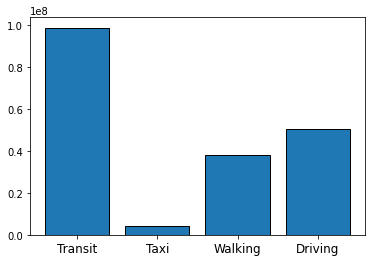

In [ ]:
## ridership by mode
byMode = data.groupby(by='tmode', as_index=False).sum()[['tmode', 'ridership']]
plt.bar(np.arange(len(byMode)), list(byMode.ridership), edgecolor = 'black')
plt.xticks([r  for r in range(len(byMode))], ['Transit', 'Taxi',
                                                      'Walking', 'Driving'], fontsize=12)

*Likelihood estimation*

In [ ]:
# choice for constant C - put as median hourly NYC income
# NYC median income is ~ $33,220 per year
# we count the total hours rather than business hours to get a somewhat lower bound estimate as people tend to undervalue the price of the time spend outside of work
# ideally C could be another parameter of the model, but here we go with a fixed estimate

C = 33220/(12*30*24)
C

3.8449074074074074

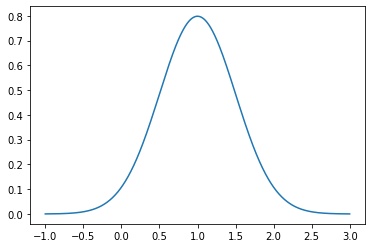

In [ ]:
# prior for lambda 

fig, ax = plt.subplots()
x= np.arange(-1,3,0.001)
ax.plot(x, norm.pdf(x, loc=1, scale=0.5))

plt.show()

In [3]:
def MNL(lambda_, data):  # multinomial logit probabilities

    # compute probabilities from utility defined above
    prob_n = np.exp(lambda_*(-(np.random.normal(loc=data['duration'].values, scale=np.sqrt(data['duration'].values))*3.84 + 
                               np.random.normal(loc=data['price'].values, scale=np.sqrt(data['price'].values))) + np.random.normal(loc=0, scale=10)))
    prob_d = np.sum(prob_n)
    pred =  prob_n/prob_d
    return pred
    
def like(lambda_, obs=data['ridership'], return_prob=False):   # compute likelihood

    pred = []
    # scale = 10000**2

    # get MNL probabilities for each o-d travel modes
    for o, d in zip(data[['pulocationid', 'dolocationid']].drop_duplicates()['pulocationid'], 
      data[['pulocationid', 'dolocationid']].drop_duplicates()['dolocationid']):   # iterate each o-d
        odLoc = data[(data.pulocationid == o) & (data.dolocationid == d)]
        pred.append(MNL(lambda_, odLoc))

    pred = np.array(list(itertools.chain(*pred)))

    pred = pred.astype(float)
    pred[pred == 0] = 0.0001

    # return_prob argument is for getting numpy array vs tensor (required for MCMC sampling)
    if return_prob == True:
        return np.sum(np.log(pred)*obs)
    else:
        return tt.sum(tt.log(pred)*obs)

In [4]:
with pm.Model() as transport_model:
    lambda1 = pm.Normal('lambda', mu=1, sd=0.5) # lambda prior

    likelihood = pm.Potential('likelihood', like(lambda1.random(), data['ridership'])) ## likelihood, we call above likelihood function with 'Potential' in pymc3
    start = pm.find_MAP()  # find max likelihood
    trace = pm.sample(1000, start=start, progressbar=True) # estimate posterior from MCMC sampling

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [lambda]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 3 seconds.


Got error No model on context stack. trying to find log_likelihood in translation.
/usr/local/lib/python3.7/dist-packages/arviz/data/io_pymc3_3x.py:102: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,
Got error No model on context stack. trying to find log_likelihood in translation.


<Figure size 720x720 with 0 Axes>

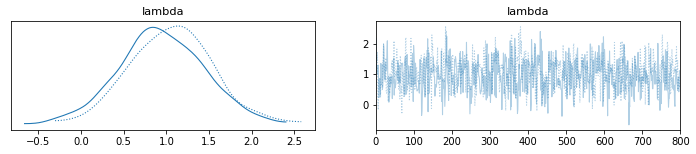

<Figure size 720x720 with 0 Axes>

In [ ]:
fig = arviz.plot_trace(trace[199:1000])
plt.figure(figsize = (10, 10))

Got error No model on context stack. trying to find log_likelihood in translation.
/usr/local/lib/python3.7/dist-packages/arviz/data/io_pymc3_3x.py:102: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


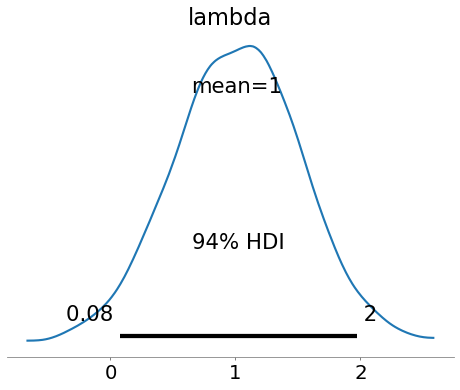

In [ ]:
arviz.plot_posterior(trace, figsize = (8, 6));

In [ ]:
# print max-likelihood lambda

print(start['lambda'])

1.0


***Assessing mode-shift in an intervention scenario***

In [ ]:
data1 = data.copy()  # make new df
data1.loc[data1.tmode == 3, 'price'] = data1.loc[data1.tmode == 3, 'price'] + 3
data1.head()

,pulocationid,dolocationid,tmode,duration,price,ridership
0,3,7,8,0.653356,12.721600,736
1,3,7,3,0.798016,46.157143,0
2,3,18,3,0.254000,15.900000,1748
3,3,18,5,1.084444,0.000000,3174
4,3,18,8,0.268923,7.432000,10879


In [ ]:
lambdas = np.random.choice(trace['lambda'], 100)  # draw samples from lambda posterior
# this step could take ~15 mins for 100 samples, reduce the number of samples for faster

likes = []   # likelihood values
mobDiff = {2:[], 3:[], 5:[], 8:[]}   # mode-shift numbers

# estimate trips for lambdas and corresponding likelihoods
for l in lambdas:
    tempMob_noInter = {2:0, 3:0, 5:0, 8:0}   
    tempMob_Inter = {2:0, 3:0, 5:0, 8:0}
    for o, d in zip(data[['pulocationid', 'dolocationid']].drop_duplicates()['pulocationid'], 
        data[['pulocationid', 'dolocationid']].drop_duplicates()['dolocationid']):
    
        odLoc_noInter = data[(data.pulocationid == o) & (data.dolocationid == d)]
        odLoc_Inter = data1[(data1.pulocationid == o) & (data1.dolocationid == d)]  
        modes = odLoc_Inter.tmode.values

        # probabilities for pre-intervention and post-intervention
        prob_noInter = MNL(l, odLoc_noInter)  
        prob_Inter = MNL(l, odLoc_Inter)    

        for index, mode in enumerate(modes):
            tempMob_Inter[mode] = tempMob_Inter[mode] + prob_Inter[index]*np.sum(odLoc_noInter['ridership'])
            tempMob_noInter[mode] = tempMob_noInter[mode] + prob_noInter[index]*np.sum(odLoc_Inter['ridership'])
        
    lhood = np.exp(like(l, return_prob=True))   # likelihood
    for it in mobDiff.keys():
        mobDiff[it].append(100.0 * tempMob_Inter[it] / tempMob_noInter[it] - 100.0)
    likes.append(lhood)
            # tempMob.update((x , y*l)for x, y in tempMob.items())

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in true_divide
  import sys


In [ ]:
# calculate average and std of mode-shift percentages (relative drop or increase in each mode usage after the intervention)

for mode in mobDiff.keys():

    mean = np.average(mobDiff[mode])
    std = abs(np.average((mobDiff[mode] - np.mean(mobDiff[mode]))**2))
    print('average change for mode', mode, ':', mean, ', std:', np.sqrt(std))

average change for mode 2 : 2.0042188004282053 , std: 2.0211513602486733
average change for mode 3 : -45.448822056952395 , std: 13.911545625117917
average change for mode 5 : nan , std: nan
average change for mode 8 : 3.811794893214037 , std: 4.3659682011603245


*Surcharge of $1 imposed on private car trips (tmode=8)*

In [ ]:
data11 = data.copy()  # make new df
data11.loc[data11.tmode == 8, 'price'] = data11.loc[data11.tmode == 8, 'price'] + 1
data11.head()

,pulocationid,dolocationid,tmode,duration,price,ridership
0,3,7,8,0.653356,13.721600,736
1,3,7,3,0.798016,43.157143,0
2,3,18,3,0.254000,12.900000,1748
3,3,18,5,1.084444,0.000000,3174
4,3,18,8,0.268923,8.432000,10879


In [ ]:
lambdas = np.random.choice(trace['lambda'], 100)  # draw samples from lambda posterior
# this step could take ~15 mins for 100 samples, reduce the number of samples for faster

likes = []   # likelihood values
mobDiff = {2:[], 3:[], 5:[], 8:[]}   # mode-shift numbers

# estimate trips for lambdas and corresponding likelihoods
for l in lambdas:
    tempMob_noInter = {2:0, 3:0, 5:0, 8:0}   
    tempMob_Inter = {2:0, 3:0, 5:0, 8:0}
    for o, d in zip(data[['pulocationid', 'dolocationid']].drop_duplicates()['pulocationid'], 
        data[['pulocationid', 'dolocationid']].drop_duplicates()['dolocationid']):
    
        odLoc_noInter = data[(data.pulocationid == o) & (data.dolocationid == d)]
        odLoc_Inter = data11[(data11.pulocationid == o) & (data11.dolocationid == d)]  
        modes = odLoc_Inter.tmode.values

        # probabilities for pre-intervention and post-intervention
        prob_noInter = MNL(l, odLoc_noInter)  
        prob_Inter = MNL(l, odLoc_Inter)    

        for index, mode in enumerate(modes):
            tempMob_Inter[mode] = tempMob_Inter[mode] + prob_Inter[index]*np.sum(odLoc_noInter['ridership'])
            tempMob_noInter[mode] = tempMob_noInter[mode] + prob_noInter[index]*np.sum(odLoc_Inter['ridership'])
        
    lhood = np.exp(like(l, return_prob=True))   # likelihood
    for it in mobDiff.keys():
        mobDiff[it].append(100.0 * tempMob_Inter[it] / tempMob_noInter[it] - 100.0)
    likes.append(lhood)
            # tempMob.update((x , y*l)for x, y in tempMob.items())

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in true_divide
  import sys


In [ ]:
# calculate average and std of mode-shift percentages (relative drop or increase in each mode usage after the intervention)

for mode in mobDiff.keys():

    mean = np.average(mobDiff[mode])
    std = abs(np.average((mobDiff[mode] - np.mean(mobDiff[mode]))**2))
    print('average change for mode', mode, ':', mean, ', std:', np.sqrt(std))

average change for mode 2 : 3.433362057635598 , std: 1.879572235990291
average change for mode 3 : 9.663983099349121 , std: 10.962332402007155
average change for mode 5 : nan , std: nan
average change for mode 8 : -14.38351291915381 , std: 4.538999877825491


*Surcharge of $5 imposed on private car trips (tmode=8)*

In [ ]:
data15 = data.copy()  # make new df
data15.loc[data15.tmode == 8, 'price'] = data15.loc[data15.tmode == 8, 'price'] + 5
data15.head()

,pulocationid,dolocationid,tmode,duration,price,ridership
0,3,7,8,0.653356,17.721600,736
1,3,7,3,0.798016,43.157143,0
2,3,18,3,0.254000,12.900000,1748
3,3,18,5,1.084444,0.000000,3174
4,3,18,8,0.268923,12.432000,10879


In [ ]:
lambdas = np.random.choice(trace['lambda'], 100)  # draw samples from lambda posterior
# this step could take ~15 mins for 100 samples, reduce the number of samples for faster

likes = []   # likelihood values
mobDiff = {2:[], 3:[], 5:[], 8:[]}   # mode-shift numbers

# estimate trips for lambdas and corresponding likelihoods
for l in lambdas:
    tempMob_noInter = {2:0, 3:0, 5:0, 8:0}   
    tempMob_Inter = {2:0, 3:0, 5:0, 8:0}
    for o, d in zip(data[['pulocationid', 'dolocationid']].drop_duplicates()['pulocationid'], 
        data[['pulocationid', 'dolocationid']].drop_duplicates()['dolocationid']):
    
        odLoc_noInter = data[(data.pulocationid == o) & (data.dolocationid == d)]
        odLoc_Inter = data15[(data15.pulocationid == o) & (data15.dolocationid == d)]  
        modes = odLoc_Inter.tmode.values

        # probabilities for pre-intervention and post-intervention
        prob_noInter = MNL(l, odLoc_noInter)  
        prob_Inter = MNL(l, odLoc_Inter)    

        for index, mode in enumerate(modes):
            tempMob_Inter[mode] = tempMob_Inter[mode] + prob_Inter[index]*np.sum(odLoc_noInter['ridership'])
            tempMob_noInter[mode] = tempMob_noInter[mode] + prob_noInter[index]*np.sum(odLoc_Inter['ridership'])
        
    lhood = np.exp(like(l, return_prob=True))   # likelihood
    for it in mobDiff.keys():
        mobDiff[it].append(100.0 * tempMob_Inter[it] / tempMob_noInter[it] - 100.0)
    likes.append(lhood)
            # tempMob.update((x , y*l)for x, y in tempMob.items())

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in true_divide
  import sys


In [ ]:
# calculate average and std of mode-shift percentages (relative drop or increase in each mode usage after the intervention)

for mode in mobDiff.keys():

    mean = np.average(mobDiff[mode])
    std = abs(np.average((mobDiff[mode] - np.mean(mobDiff[mode]))**2))
    print('average change for mode', mode, ':', mean, ', std:', np.sqrt(std))

average change for mode 2 : 12.019605969835313 , std: 4.839335100122702
average change for mode 3 : 30.792097324857693 , std: 13.958756047631312
average change for mode 5 : nan , std: nan
average change for mode 8 : -51.21676135177254 , std: 13.147282586879538


*Surcharge of $10 imposed on private car trips (tmode=8)*

In [ ]:
data110 = data.copy()  # make new df
data110.loc[data110.tmode == 8, 'price'] = data110.loc[data110.tmode == 8, 'price'] + 10
data110.head()

,pulocationid,dolocationid,tmode,duration,price,ridership
0,3,7,8,0.653356,22.721600,736
1,3,7,3,0.798016,43.157143,0
2,3,18,3,0.254000,12.900000,1748
3,3,18,5,1.084444,0.000000,3174
4,3,18,8,0.268923,17.432000,10879


In [ ]:
lambdas = np.random.choice(trace['lambda'], 100)  # draw samples from lambda posterior
# this step could take ~15 mins for 100 samples, reduce the number of samples for faster

likes = []   # likelihood values
mobDiff = {2:[], 3:[], 5:[], 8:[]}   # mode-shift numbers

# estimate trips for lambdas and corresponding likelihoods
for l in lambdas:
    tempMob_noInter = {2:0, 3:0, 5:0, 8:0}   
    tempMob_Inter = {2:0, 3:0, 5:0, 8:0}
    for o, d in zip(data[['pulocationid', 'dolocationid']].drop_duplicates()['pulocationid'], 
        data[['pulocationid', 'dolocationid']].drop_duplicates()['dolocationid']):
    
        odLoc_noInter = data[(data.pulocationid == o) & (data.dolocationid == d)]
        odLoc_Inter = data110[(data110.pulocationid == o) & (data110.dolocationid == d)]  
        modes = odLoc_Inter.tmode.values

        # probabilities for pre-intervention and post-intervention
        prob_noInter = MNL(l, odLoc_noInter)  
        prob_Inter = MNL(l, odLoc_Inter)    

        for index, mode in enumerate(modes):
            tempMob_Inter[mode] = tempMob_Inter[mode] + prob_Inter[index]*np.sum(odLoc_noInter['ridership'])
            tempMob_noInter[mode] = tempMob_noInter[mode] + prob_noInter[index]*np.sum(odLoc_Inter['ridership'])
        
    lhood = np.exp(like(l, return_prob=True))   # likelihood
    for it in mobDiff.keys():
        mobDiff[it].append(100.0 * tempMob_Inter[it] / tempMob_noInter[it] - 100.0)
    likes.append(lhood)
            # tempMob.update((x , y*l)for x, y in tempMob.items())

In [ ]:
# calculate average and std of mode-shift percentages (relative drop or increase in each mode usage after the intervention)

for mode in mobDiff.keys():

    mean = np.average(mobDiff[mode])
    std = abs(np.average((mobDiff[mode] - np.mean(mobDiff[mode]))**2))
    print('average change for mode', mode, ':', mean, ', std:', np.sqrt(std))

average change for mode 2 : 15.370800615000842 , std: 8.573633392479541
average change for mode 3 : 47.581405492007335 , std: 20.23267021002479
average change for mode 5 : 12.507062018247375 , std: 7.914671121032594
average change for mode 8 : -68.81824866578779 , std: 24.391578327778277


*Surcharge of $3 surcharge to taxi trips, but added only to trips originating from Manhattan*

In [5]:
#!pip install geopandas
import geopandas as gpd

# taxi zone data
zip = gpd.read_file('https://github.com/CUSP2022ADS/Data/raw/main/taxizone.geojson')
zip = zip[['location_id', 'borough', 'zone']]
zip['location_id'] = pd.to_numeric(zip['location_id'])
zip.head()

,location_id,borough,zone
0,1,EWR,Newark Airport
1,2,Queens,Jamaica Bay
2,3,Bronx,Allerton/Pelham Gardens
3,4,Manhattan,Alphabet City
4,5,Staten Island,Arden Heights


In [6]:
data2 = data.copy()  # make new df
data2 = data2.merge(zip, how='left', left_on='pulocationid', right_on='location_id') # merge df with zip file
data2.tail()

,pulocationid,dolocationid,tmode,duration,price,ridership,location_id,borough,zone
38344,263,261,8,0.423988,24.843939,46,263,Manhattan,Yorkville West
38345,263,262,3,0.109960,5.100715,1840,263,Manhattan,Yorkville West
38346,263,262,2,0.133333,2.750000,7705,263,Manhattan,Yorkville West
38347,263,262,8,0.109435,15.386033,7981,263,Manhattan,Yorkville West
38348,263,262,5,0.142500,0.000000,93679,263,Manhattan,Yorkville West


In [7]:
data2.loc[(data2.tmode == 3) & (data2.borough == 'Manhattan'), 'price'] = data2.loc[(data2.tmode == 3) & (data2.borough == 'Manhattan'), 'price'] + 3
data2.tail()

,pulocationid,dolocationid,tmode,duration,price,ridership,location_id,borough,zone
38344,263,261,8,0.423988,24.843939,46,263,Manhattan,Yorkville West
38345,263,262,3,0.109960,8.100715,1840,263,Manhattan,Yorkville West
38346,263,262,2,0.133333,2.750000,7705,263,Manhattan,Yorkville West
38347,263,262,8,0.109435,15.386033,7981,263,Manhattan,Yorkville West
38348,263,262,5,0.142500,0.000000,93679,263,Manhattan,Yorkville West


In [24]:
ndata = data2.drop(columns=['location_id','borough','zone'])
ndata.tail()

,pulocationid,dolocationid,tmode,duration,price,ridership
38344,263,261,8,0.423988,24.843939,46
38345,263,262,3,0.109960,8.100715,1840
38346,263,262,2,0.133333,2.750000,7705
38347,263,262,8,0.109435,15.386033,7981
38348,263,262,5,0.142500,0.000000,93679


In [ ]:
lambdas = np.random.choice(trace['lambda'], 100)  # draw samples from lambda posterior
# this step could take ~15 mins for 100 samples, reduce the number of samples for faster

likes = []   # likelihood values
mobDiff = {2:[], 3:[], 5:[], 8:[]}   # mode-shift numbers

# estimate trips for lambdas and corresponding likelihoods
for l in lambdas:
    tempMob_noInter = {2:0, 3:0, 5:0, 8:0}   
    tempMob_Inter = {2:0, 3:0, 5:0, 8:0}
    for o, d in zip(data[['pulocationid', 'dolocationid']].drop_duplicates()['pulocationid'], 
        data[['pulocationid', 'dolocationid']].drop_duplicates()['dolocationid']):
    
        odLoc_noInter = data[(data.pulocationid == o) & (data.dolocationid == d)]
        odLoc_Inter = data2[(data2.pulocationid == o) & (data2.dolocationid == d)]  
        modes = odLoc_Inter.tmode.values

        # probabilities for pre-intervention and post-intervention
        prob_noInter = MNL(l, odLoc_noInter)  
        prob_Inter = MNL(l, odLoc_Inter)    

        for index, mode in enumerate(modes):
            tempMob_Inter[mode] = tempMob_Inter[mode] + prob_Inter[index]*np.sum(odLoc_noInter['ridership'])
            tempMob_noInter[mode] = tempMob_noInter[mode] + prob_noInter[index]*np.sum(odLoc_Inter['ridership'])
        
    lhood = np.exp(like(l, return_prob=True))   # likelihood
    for it in mobDiff.keys():
        mobDiff[it].append(100.0 * tempMob_Inter[it] / tempMob_noInter[it] - 100.0)
    likes.append(lhood)
            # tempMob.update((x , y*l)for x, y in tempMob.items())

In [ ]:
# calculate average and std of mode-shift percentages (relative drop or increase in each mode usage after the intervention)

for mode in mobDiff.keys():

    mean = np.average(mobDiff[mode])
    std = abs(np.average((mobDiff[mode] - np.mean(mobDiff[mode]))**2))
    print('average change for mode', mode, ':', mean, ', std:', np.sqrt(std))